# Bird Modelling

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [5]:
df = pd.read_csv('birds_ch_2018-2022.csv', delimiter=';')

## Data preparation

In [6]:
# Map precisions
precisions = {'Exakte Lokalisierung': 0, 'Kilometerquadrat': 1, 'Ort': 2}
df['PRECISION'] = df['PRECISION'].map(precisions)
df['PRECISION'] = df['PRECISION'].astype(int)

In [7]:
# Split date in three features day, month, year
df[['YEAR', 'MONTH', 'DAY']] = df['DATE'].str.split('-', expand=True).astype(int)
df.drop(columns='DATE', inplace= True)

In [8]:
# Only keep hour of day
df['TIMING'] = df['TIMING'].apply(lambda x: int(x.split(':')[0]) if type(x)!=float else x)

In [9]:
# drastic: Drop every row that has no time (60%!) or no bird count
df = df[df['TIMING'].notna()]
df = df[df['ID_OBSERVER'].notna()]
df.drop(columns='TOTAL_COUNT', inplace= True)

In [10]:
df['NAME_SPECIES'] = df['NAME_SPECIES'].astype(str)

In [11]:
y = df['NAME_SPECIES']
X = df.drop(columns=['NAME_SPECIES', 'ID_SPECIES', 'ID_SIGHTING'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)

## Relevant EDA for modeling

### Dataset balance
Dataset balance refers to the distribution of various classes or categories present within the dataset. A balanced dataset is characterized by a roughly equal number of instances across each class or category, whereas an imbalanced dataset exhibits notable disparities in the instance counts among the classes.

Dataset balance can have a significant impact on the performance and accuracy of predictive models. Imbalanced datasets can introduce bias in machine learning models. If one class has a much larger number of instances compared to others, the model may become biased towards that dominant class. Consequently, the model's predictions may be skewed, favoring the majority class while performing poorly on minority classes.

In our case, the plot below shows that the amount of sights per species are highly imbalanced. It is worth noting that real-world phenomena often exhibit imbalanced class distributions due to the nature of the problem. In such scenarios, the dataset's class distribution naturally reflects the underlying distribution in the real world, making it acceptable to have an imbalanced dataset.

In [12]:
n_per_species = df.groupby('NAME_SPECIES').size()
fig = px.bar(n_per_species)
fig.show()

### Principal Component Analysis (PCA)
The key aim of PCA is to reduce the number of variables of a data set, while preserving as much information as possible.
PCA helps to remove all the features that are correlated, a phenomenon known as multi-collinearity. 

Text(7, 0.75, 'strong correlation')

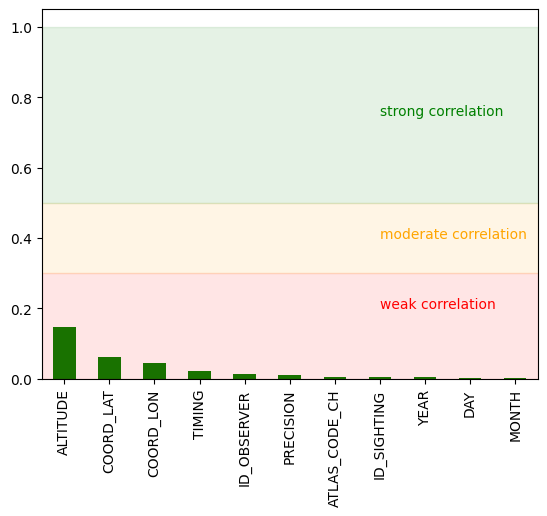

In [13]:
### Get correlation of each feature with respect to the target (bird species)
df_for_pca = df.drop(columns=['NAME_SPECIES'])
df_corr = df_for_pca.corr()['ID_SPECIES'].abs().sort_values(ascending=False)
df_corr.drop('ID_SPECIES', inplace=True)
ax = df_corr.plot.bar(color='green')

ax.axhspan(0, 0.3, alpha=0.1, color='red')
ax.axhspan(0.3, 0.5, alpha=0.1, color='orange')
ax.axhspan(0.5, 1, alpha=0.1, color='green')
ax.text(7,0.2, s='weak correlation', color='red')
ax.text(7,0.4, s='moderate correlation', color='orange')
ax.text(7,0.75, s='strong correlation', color='green')

### Featureverteilungen


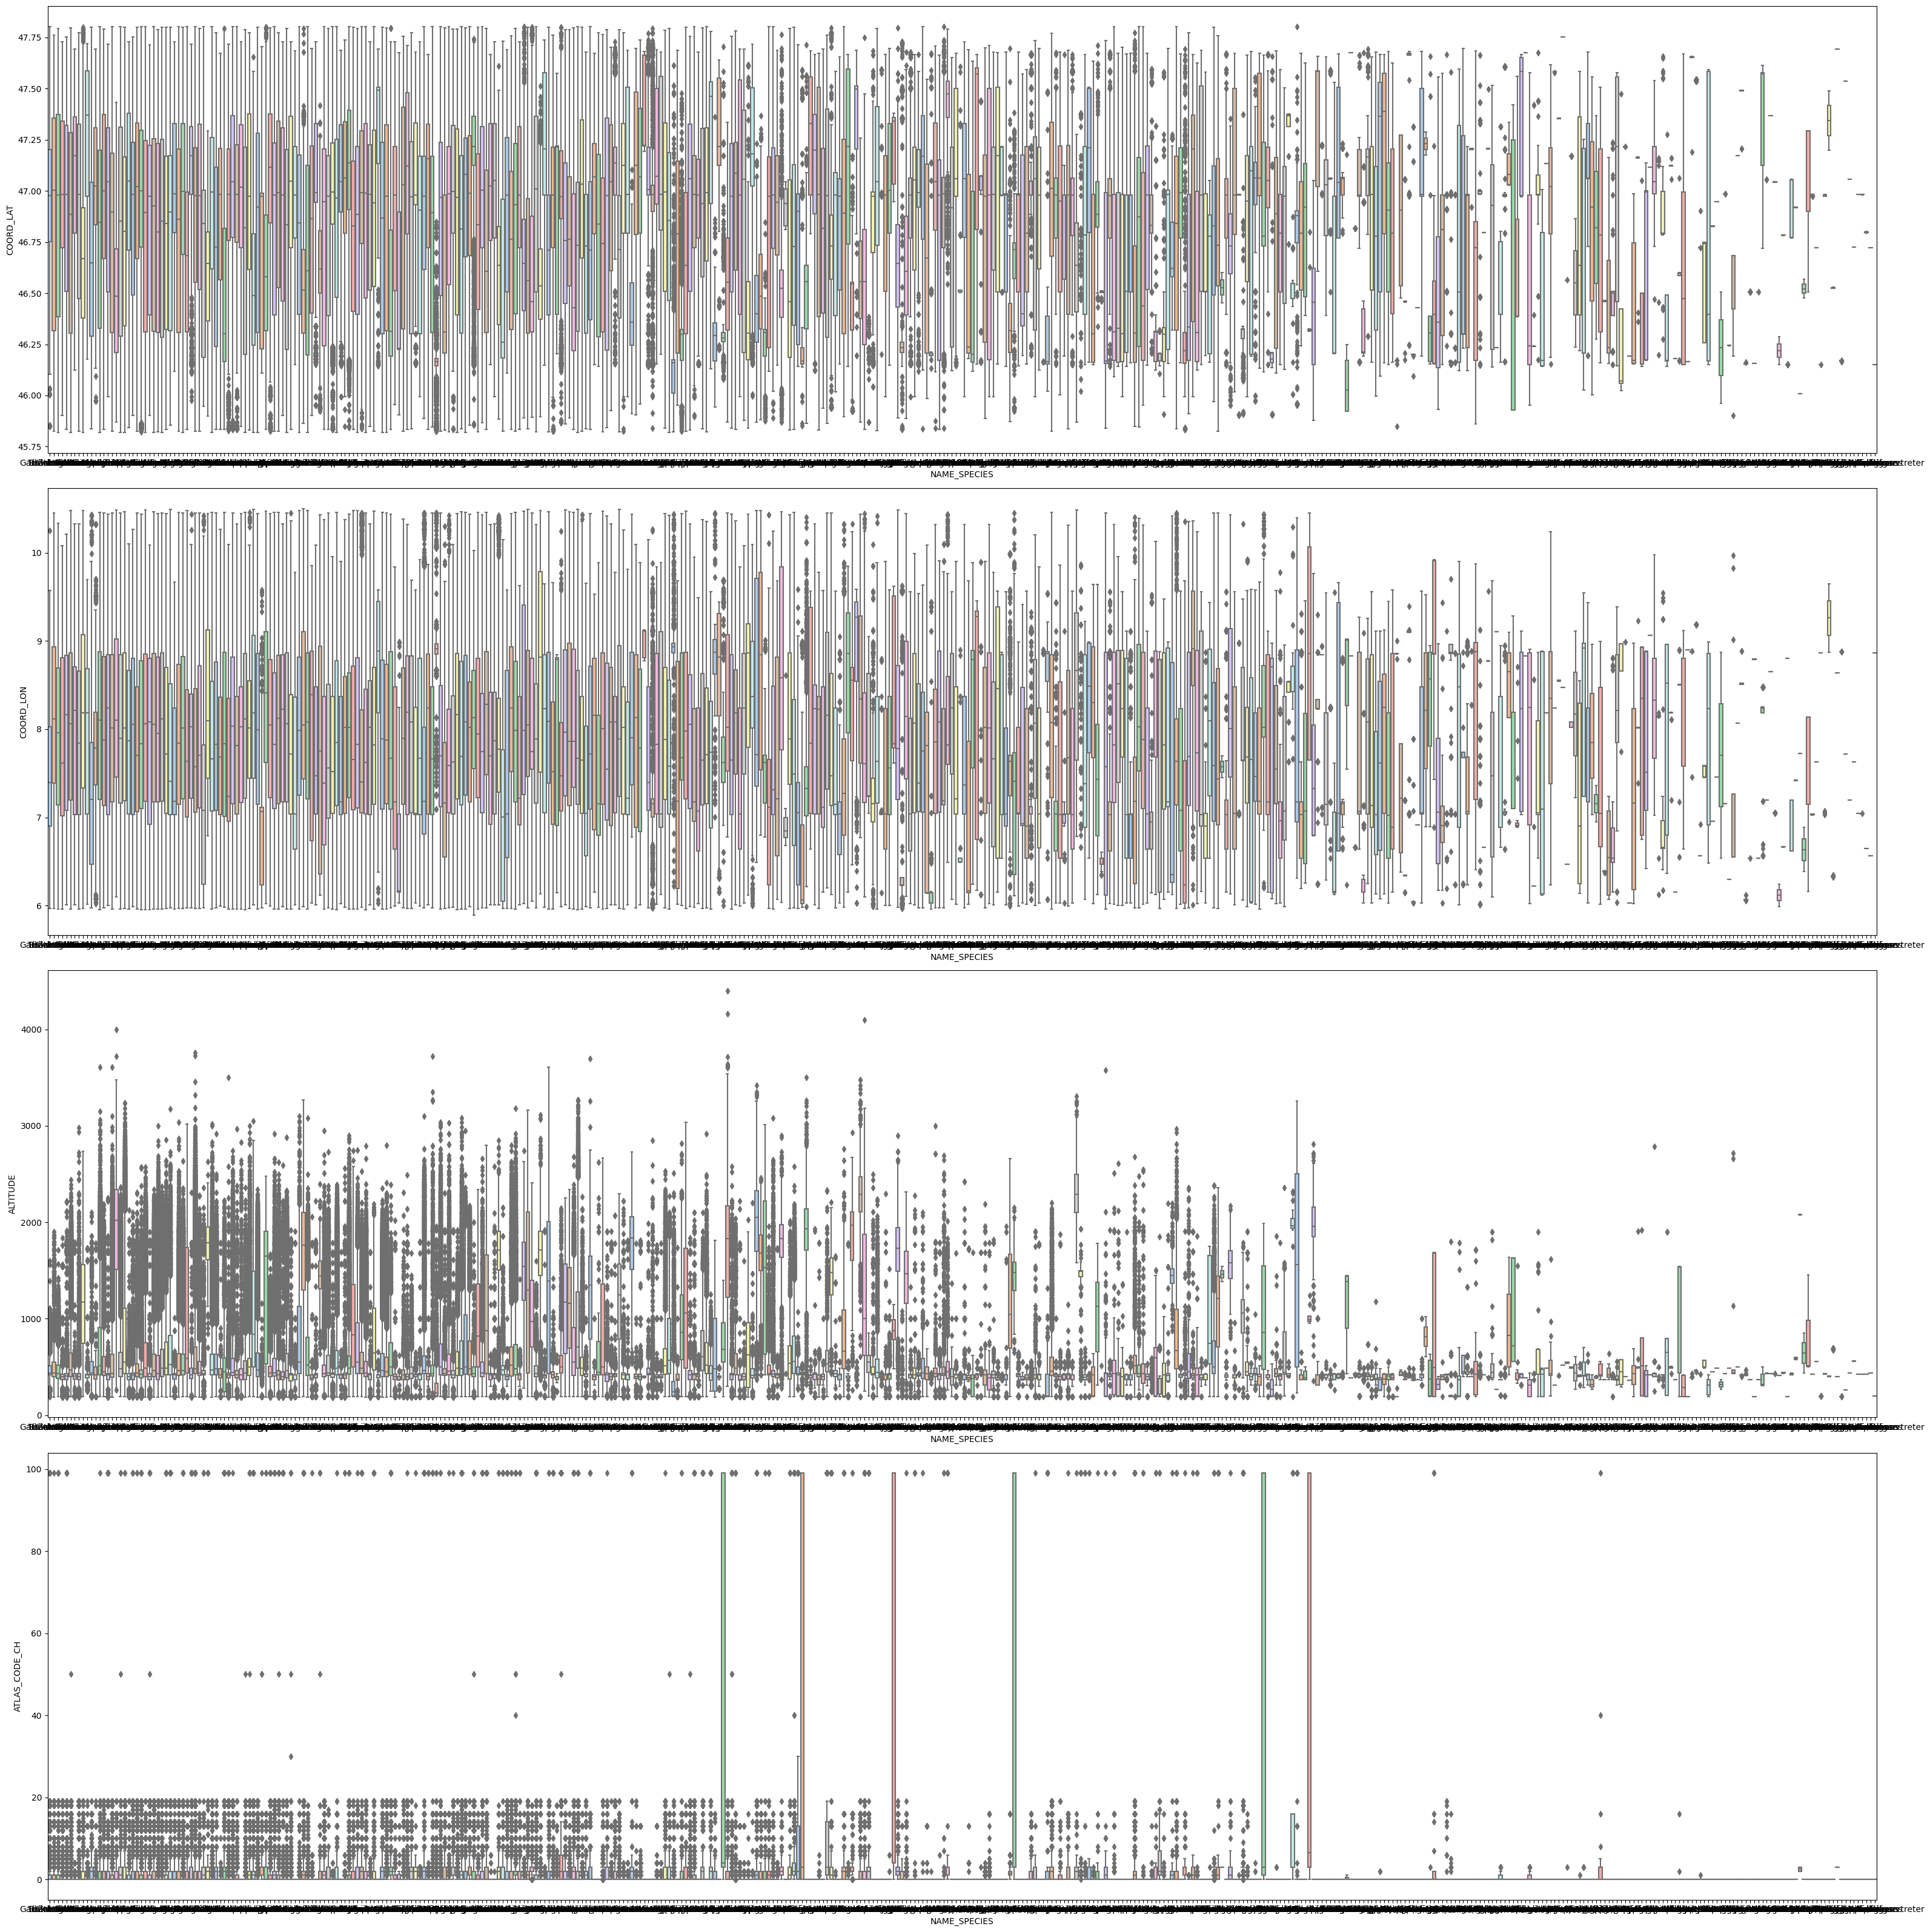

In [14]:
fig, axes = plt.subplots(4, 1, figsize=(32, 32))
sns.boxplot(data=df, x='NAME_SPECIES', y='COORD_LAT', ax=axes[0], palette='pastel')
sns.boxplot(data=df, x='NAME_SPECIES', y='COORD_LON', ax=axes[1], palette='pastel')
sns.boxplot(data=df, x='NAME_SPECIES', y='ALTITUDE', ax=axes[2], palette='pastel')
sns.boxplot(data=df, x='NAME_SPECIES', y='ATLAS_CODE_CH', ax=axes[3], palette='pastel')

#sns.boxplot(data=df, x='NAME_SPECIES', y='TIMING', ax=axes[4], palette='pastel')
#sns.boxplot(data=df, x='NAME_SPECIES', y='YEAR', ax=axes[5], palette='pastel')
#sns.boxplot(data=df, x='NAME_SPECIES', y='MONTH', ax=axes[6], palette='pastel')
#sns.boxplot(data=df, x='NAME_SPECIES', y='DAY', ax=axes[7], palette='pastel')

plt.tight_layout();

## Modelling

### Modelling on 497 bird species

In [15]:
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('TREE', DecisionTreeClassifier()))
models.append(('SVM', SVC()))

In [16]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.07622399337542697

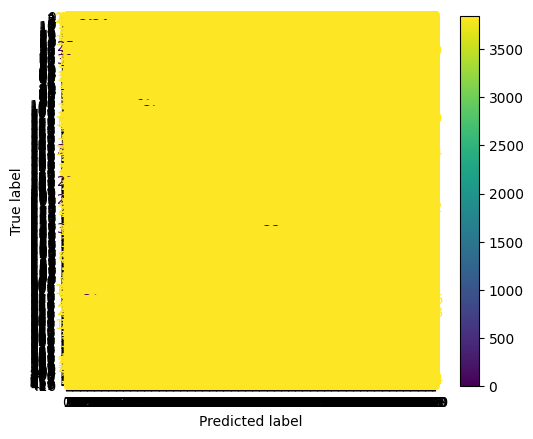

In [18]:
y_pred = model.predict(X_test)
res = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=res).plot()
plt.show()

### Modelling on 137 bird species (>=5000 sightings)

In [19]:
frequent_birdos = df['NAME_SPECIES'].value_counts().loc[lambda s: s > 50000].index.tolist()
trimmed = df[df['NAME_SPECIES'].isin(frequent_birdos)]

y_trimmed = trimmed['NAME_SPECIES']
X_trimmed = trimmed.drop(columns=['NAME_SPECIES', 'ID_SPECIES', 'ID_SIGHTING'])
X_train_trimmed, X_test_trimmed, y_train_trimmed, y_test_trimmed = train_test_split(X_trimmed, y_trimmed, test_size=0.25, random_state=24)

In [20]:
n_species = trimmed['NAME_SPECIES'].nunique()
print('Number of species in dataset:', n_species)

Number of species in dataset: 18


In [21]:
model_trimmed = DecisionTreeClassifier()
model_trimmed.fit(X_train_trimmed, y_train_trimmed)
model_trimmed.score(X_test_trimmed, y_test_trimmed)

0.13147859647182097

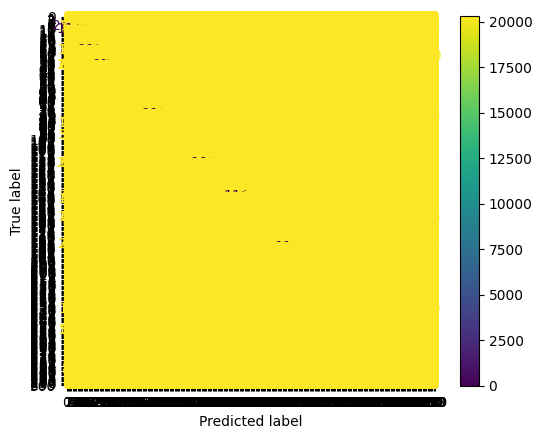

In [23]:
y_pred_trimmed = model.predict(X_test_trimmed)
res_trimmed = confusion_matrix(y_test_trimmed, y_pred_trimmed)
ConfusionMatrixDisplay(confusion_matrix=res_trimmed).plot()
plt.show()

In [29]:
y_test_trimmed.nunique()

18

In [ ]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    print('Training', name, '...')
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    results.append(acc)
    names.append(name)
    print('Accuracy of ', name, ':', acc)

Training LR ...


In [ ]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

- 137 species (>5000) -> 0.076 (Tree), 0.048 (KNN)
- 18 species (>50.000) -> 0.13